# Rescheduling mit Tardiness (Summe)
> Planunghorizont Tag 0: 2 Tage
> Rescheduling des Tages 1

In [42]:
max_time = 60*15 # 15min

In [43]:
import time

In [44]:
from ortools.sat.python import cp_model
import pandas as pd
import numpy as np
import math

pd.set_option('display.max_rows', 20)

In [45]:
import utils.presenter as show
import utils.checker as check

import utils.schedule_interarrival as sit
import utils.scheduling_solver as ssv

from ProductionDaySimulation import ProductionDaySimulation

In [46]:
import utils.rolling_planning.init_jobs_times as rp_init
import utils.schedule_deadline as deadline_gen

In [47]:
df_instance = pd.read_csv("data/00_instance.csv")
df_instance

,Job,Operation,Machine,Processing Time
0,job 0,0,M0,29
1,job 0,1,M1,78
2,job 0,2,M2,9
3,job 0,3,M3,36
4,job 0,4,M4,49
...,...,...,...,...
95,job 9,5,M9,76
96,job 9,6,M5,47
97,job 9,7,M3,52
98,job 9,8,M4,90


In [48]:
df_ops, df_jobs = rp_init.init_jobs_with_arrivals(df_instance, 28,  u_b_mmax = 0.95)
df_jobs

,Job,Arrival
0,Job_000,0.00
1,Job_001,83.42
2,Job_002,144.74
3,Job_003,197.03
4,Job_004,233.63
...,...,...
527,Job_527,40008.21
528,Job_528,40014.27
529,Job_529,40015.63
530,Job_530,40134.35


In [49]:
# a) Initialisierung der Deadlines
df_jobs = deadline_gen.get_times_df(df_ops, df_jobs, ssv.schedule_fcfs_with_arrivals, target_service=1.0)

# Rundung für CP 
df_jobs["Arrival"] = np.floor(df_jobs["Arrival"]).astype(int)
df_jobs["Deadline"] = np.ceil(df_jobs["Deadline"]).astype(int)
df_jobs.head()

,Job,Arrival,Deadline
0,Job_000,0,1204
1,Job_001,83,1637
2,Job_002,144,1875
3,Job_003,197,2193
4,Job_004,233,1431


In [50]:
# b) Bestimmung der "Ready Time"
df_jobs['Ready Time'] = ((df_jobs['Arrival'] // 1440) + 1) * 1440

# c) Processing Time
processing_time = df_ops.groupby('Job')['Processing Time'].sum()
df_jobs = pd.merge(df_jobs, processing_time, on='Job')

# d) Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])

# e) Anpassung der Deadlines
min_slack = df_jobs['Slack'].min()

if min_slack < 0:
    df_jobs["Deadline"] = df_jobs["Deadline"] + abs(min_slack)
df_jobs

# f) erneute Bestimmung des Slacks
df_jobs['Slack'] = df_jobs['Deadline'] - (df_jobs['Ready Time'] + df_jobs['Processing Time'])
df_jobs 

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,83,2268,1440,510,318
2,Job_002,144,2506,1440,568,498
3,Job_003,197,2824,1440,655,729
4,Job_004,233,2062,1440,393,229
...,...,...,...,...,...,...
527,Job_527,40008,42635,40320,655,1660
528,Job_528,40014,41843,40320,393,1130
529,Job_529,40015,42377,40320,568,1489
530,Job_530,40134,41969,40320,395,1254


In [51]:
day_length = 1440

## I) Tag 1

In [52]:
day_numb = 1

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 01: [1440, 2880)


In [53]:
def filter_ops_and_jobs_by_ready_time(df_jobs: pd.DataFrame, df_ops: pd.DataFrame, 
                              ready_time_col = "Ready Time", ready_time: int = 0) -> tuple[pd.DataFrame, pd.DataFrame]:

    # Jobs zeitlich filtern
    time_filter = df_jobs[ready_time_col] == ready_time
    df_jobs_filtered = df_jobs[time_filter].copy()

    # Operationen nach (gefilterten) Jobs filtern
    jobs = df_jobs_filtered["Job"]
    df_ops_filtered = df_ops[df_ops["Job"].isin(jobs)].copy()
    return df_jobs_filtered, df_ops_filtered

In [54]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_000,0,1835,1440,395,0
1,Job_001,83,2268,1440,510,318
2,Job_002,144,2506,1440,568,498
3,Job_003,197,2824,1440,655,729
4,Job_004,233,2062,1440,393,229
5,Job_005,302,2445,1440,496,509
6,Job_006,340,2239,1440,416,383
7,Job_007,488,2762,1440,539,783
8,Job_008,708,3159,1440,597,1122
9,Job_009,740,3017,1440,540,1037


### A) Scheduling für Tag 1

In [55]:
starting_time = time.time()

# Scheduling
df_plan = ssv.solve_cp_jssp_lateness_by_tardiness_and_earliness(df_ops_curr, df_jobs_curr, w_t = 5,
                                                                schedule_start = 1440,
                                                                msg=False, timeLimit=max_time, gapRel= 0.00)
df_plan

# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_plan


Solver-Status         : OPTIMAL
Objective Value       : 51.00
Best Objective Bound  : 51.00
Laufzeit              : 0.11 Sekunden

Scheduling-Dauer: 0 Minuten und 0.13 Sekunden.


,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_004,0,M2,233,2062,1440,14,1454,-608,0,608
2,Job_015,0,M2,1134,2963,1454,14,1468,-1495,0,1495
3,Job_010,0,M2,845,3118,1468,31,1499,-1619,0,1619
4,Job_000,1,M1,0,1835,1469,78,1547,-288,0,288
...,...,...,...,...,...,...,...,...,...,...,...
185,Job_016,7,M6,1135,3497,3278,89,3367,-130,0,130
186,Job_016,8,M9,1135,3497,3367,45,3412,-85,0,85
187,Job_016,9,M4,1135,3497,3464,33,3497,0,0,0
188,Job_018,9,M7,1354,3631,3586,45,3631,0,0,0


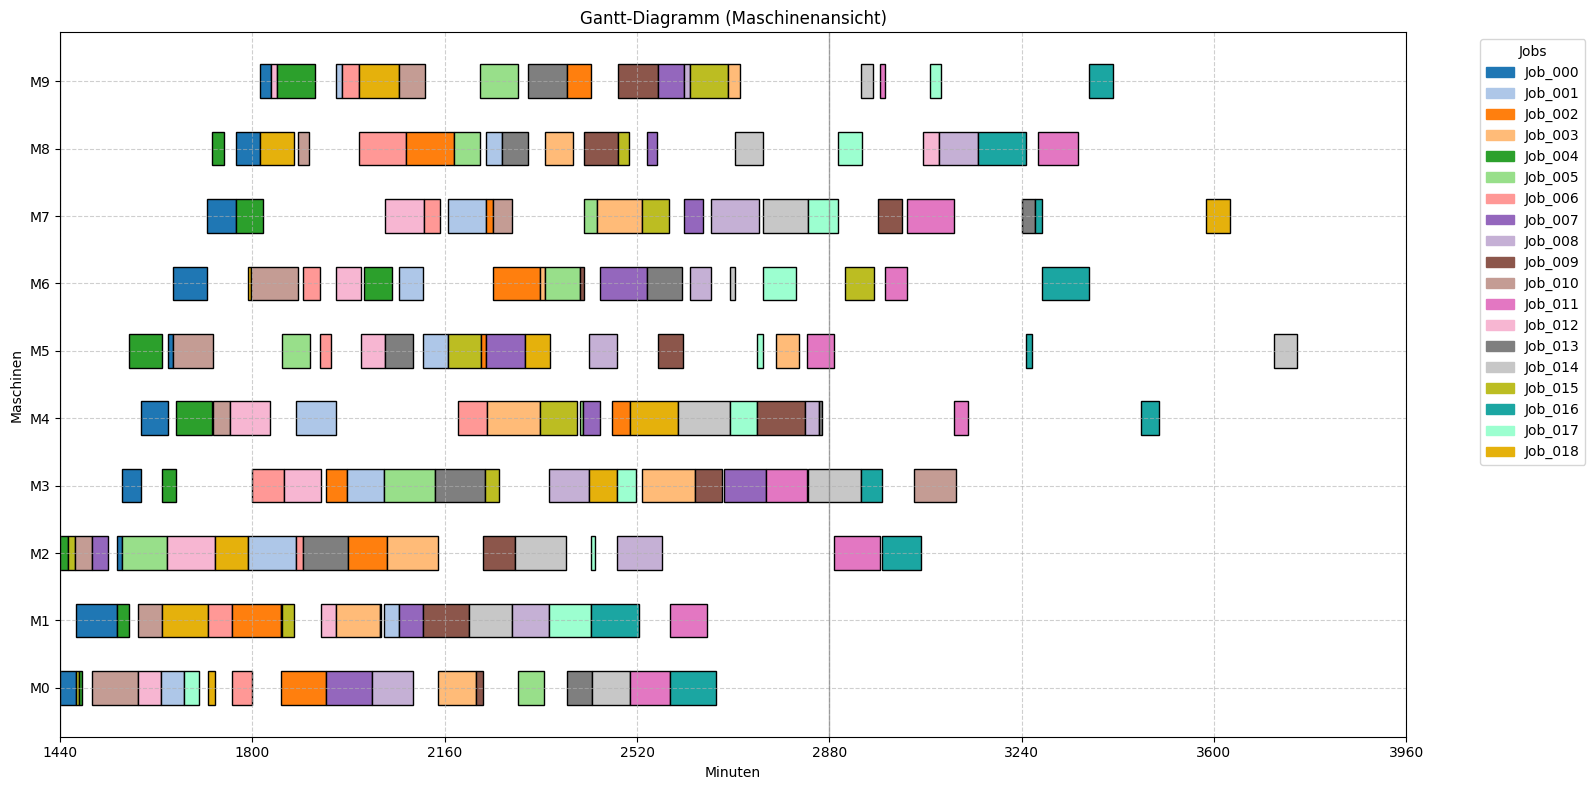

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [56]:
show.plot_gantt_machines(df_plan)

check.is_machine_conflict_free(df_plan)
check.is_operation_sequence_correct(df_plan)
check.is_job_timing_correct(df_plan)
check.is_start_correct(df_plan)

### B) Aufteilung in heutige und zukünftge Operationen

In [57]:
def filter_plan_for_today(df_plan, latest_op_start: int = 0): # exclusive
    filt = (df_plan.Start < latest_op_start)
    return df_plan[filt].sort_values(by="Job").reset_index(drop=True)

In [58]:
df_plan_for_sim = filter_plan_for_today(df_plan, latest_op_start = day_end)
df_plan_for_sim

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_000,0,M0,0,1835,1440,29,1469,-366,0,366
1,Job_000,6,M6,0,1835,1652,62,1714,-121,0,121
2,Job_000,7,M7,0,1835,1714,56,1770,-65,0,65
3,Job_000,8,M8,0,1835,1770,44,1814,-21,0,21
4,Job_000,3,M3,0,1835,1556,36,1592,-243,0,243
...,...,...,...,...,...,...,...,...,...,...,...
160,Job_018,1,M0,1354,3631,1716,13,1729,-1902,0,1902
161,Job_018,8,M4,1354,3631,2506,90,2596,-1035,0,1035
162,Job_018,6,M5,1354,3631,2311,47,2358,-1273,0,1273
163,Job_018,4,M8,1354,3631,1814,64,1878,-1753,0,1753


In [59]:
def filter_plan_for_future(df_plan, earliest_op_start: int = 0):
    filt = (df_plan.Start >= earliest_op_start)
    return df_plan[filt].sort_values(by=["Job", "Start"]).reset_index(drop=True)

In [60]:
df_plan_waiting = filter_plan_for_future(df_plan, earliest_op_start = day_end)
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,9,M8,708,3159,3085,74,3159,0,0,0
1,Job_009,9,M7,740,3017,2972,45,3017,0,0,0
2,Job_010,9,M3,845,3118,3039,79,3118,0,0,0
3,Job_011,4,M2,894,3345,2889,85,2974,-371,0,371
4,Job_011,5,M9,894,3345,2974,11,2985,-360,0,360
...,...,...,...,...,...,...,...,...,...,...,...
20,Job_016,8,M9,1135,3497,3367,45,3412,-85,0,85
21,Job_016,9,M4,1135,3497,3464,33,3497,0,0,0
22,Job_017,8,M8,1254,3089,2897,44,2941,-148,0,148
23,Job_017,9,M9,1254,3089,3068,21,3089,0,0,0


### C) Simulation

In [61]:
simulation = ProductionDaySimulation(df_plan_for_sim, vc=0.35)
df_execution, df_plan_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:00:00] Job_000 started on M0
[24:00:00] Job_004 started on M2
[24:13:12] Job_000 finished on M0 (after 13 minutes 12 seconds)
[24:19:10] Job_004 finished on M2 (after 19 minutes 10 seconds)
[24:19:10] Job_015 started on M2
[24:29:00] Job_000 started on M1
[24:35:00] Job_004 started on M0
[24:36:28] Job_015 finished on M2 (after 17 minutes 19 seconds)
[24:36:28] Job_010 started on M2
[24:43:55] Job_004 finished on M0 (after 08 minutes 55 seconds)
[24:43:55] Job_015 started on M0
[24:49:07] Job_015 finished on M0 (after 05 minutes 13 seconds)
[25:25:25] Job_010 finished on M2 (after 48 minutes 57 seconds)
[25:25:25] Job_007 started on M2
[25:25:25] Job_010 started on M0
[25:46:16] Job_007 finished on M2 (after 20 minutes 51 seconds)
[25:56:00] Job_005 started on M2
[26:16:13] Job_000 finished on M1 (after 107 minutes 13 seconds)
[26:16:13] Job_004 started on M1
[26:31:40] Job_010 finished on M0 (after 66 minutes 14 seconds)
[26:31:40] Job_012 started on M0
[26:44:48] Job_004 finished

In [62]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
70,Job_007,9,M3,488,2762,2683,79,2762,0,0,0
86,Job_008,7,M7,708,3159,2659,89,2748,-411,0,411
87,Job_008,8,M4,708,3159,2834,26,2860,-299,0,299
110,Job_011,3,M5,894,3345,2838,51,2889,-456,0,456
135,Job_014,6,M7,1128,3755,2756,85,2841,-914,0,914
133,Job_014,7,M3,1128,3755,2841,98,2939,-816,0,816
149,Job_017,7,M7,1254,3089,2841,56,2897,-192,0,192


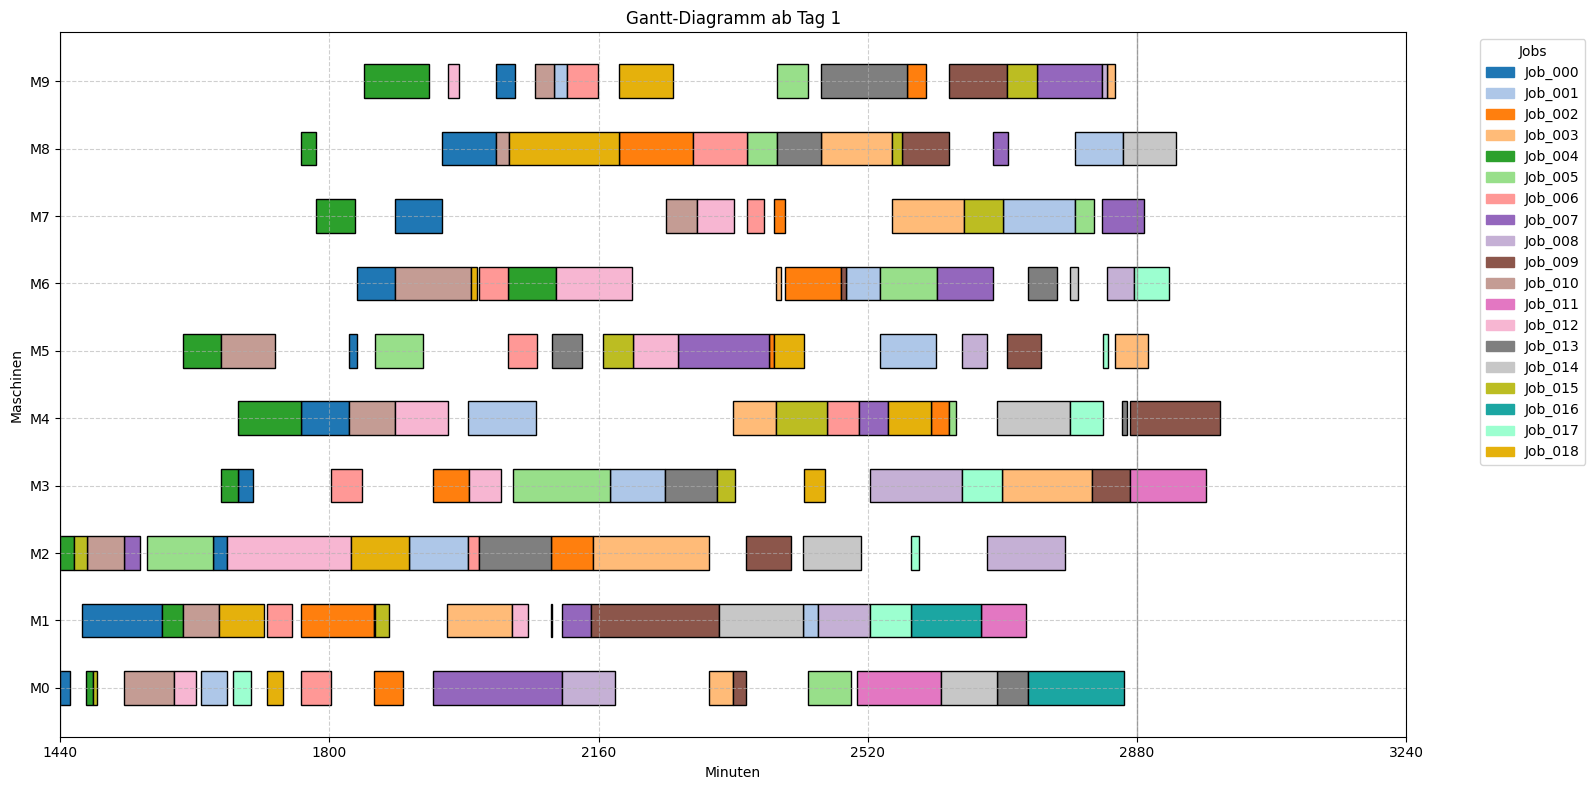

In [63]:
if not df_execution.empty:
    show.plot_gantt_machines(df_execution, title=f"Gantt-Diagramm ab Tag {day_numb}", duration_column="Simulated Processing Time")
else:
    print(f"Nothing executed on day {day_numb}")

## II) Tag 2
> vereinfacht, ohne neu Aufträge (nur der Rest)

In [64]:
day_numb = 2

day_start = day_length*day_numb 
day_end = day_start + day_length
print(f"Tag {day_numb:02d}: [{day_start}, {day_end})")

Tag 02: [2880, 4320)


#### a) Filtern nach der aktuellen "Ready Time"

In [65]:
df_jobs_curr, df_ops_curr = filter_ops_and_jobs_by_ready_time(df_jobs, df_ops, ready_time = day_start)
df_jobs_curr

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
19,Job_019,1440,3275,2880,395,0
20,Job_020,1523,3708,2880,510,318
21,Job_021,1584,3946,2880,568,498
22,Job_022,1637,4264,2880,655,729
23,Job_023,1673,3502,2880,393,229
24,Job_024,1742,3885,2880,496,509
25,Job_025,1780,3679,2880,416,383
26,Job_026,1928,4202,2880,539,783
27,Job_027,2148,4599,2880,597,1122
28,Job_028,2180,4457,2880,540,1037


### b) Operationen, die zuvor "ready" waren, aber noch nicht starten sollten

In [66]:
df_plan_waiting

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_008,9,M8,708,3159,3085,74,3159,0,0,0
1,Job_009,9,M7,740,3017,2972,45,3017,0,0,0
2,Job_010,9,M3,845,3118,3039,79,3118,0,0,0
3,Job_011,4,M2,894,3345,2889,85,2974,-371,0,371
4,Job_011,5,M9,894,3345,2974,11,2985,-360,0,360
...,...,...,...,...,...,...,...,...,...,...,...
20,Job_016,8,M9,1135,3497,3367,45,3412,-85,0,85
21,Job_016,9,M4,1135,3497,3464,33,3497,0,0,0
22,Job_017,8,M8,1254,3089,2897,44,2941,-148,0,148
23,Job_017,9,M9,1254,3089,3068,21,3089,0,0,0


In [67]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_waiting = df_ops.merge(df_plan_waiting[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_waiting

,Job,Operation,Machine,Processing Time
0,Job_008,9,M8,74
1,Job_009,9,M7,45
2,Job_010,9,M3,79
3,Job_011,4,M2,85
4,Job_011,5,M9,11
...,...,...,...,...
20,Job_016,8,M9,45
21,Job_016,9,M4,33
22,Job_017,8,M8,44
23,Job_017,9,M9,21


In [68]:
df_jobs_waiting = df_jobs[df_jobs["Job"].isin(df_plan_waiting["Job"].unique())]
df_jobs_waiting

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
8,Job_008,708,3159,1440,597,1122
9,Job_009,740,3017,1440,540,1037
10,Job_010,845,3118,1440,539,1139
11,Job_011,894,3345,1440,597,1308
12,Job_012,950,3136,1440,510,1186
13,Job_013,1123,3266,1440,496,1330
14,Job_014,1128,3755,1440,655,1660
15,Job_015,1134,2963,1440,393,1130
16,Job_016,1135,3497,1440,568,1489
17,Job_017,1254,3089,1440,395,1254


#### c) Unerledigte Operationen

In [69]:
df_plan_undone

,Job,Operation,Machine,Arrival,Deadline,Start,Processing Time,End,Lateness,Tardiness,Earliness
70,Job_007,9,M3,488,2762,2683,79,2762,0,0,0
86,Job_008,7,M7,708,3159,2659,89,2748,-411,0,411
87,Job_008,8,M4,708,3159,2834,26,2860,-299,0,299
110,Job_011,3,M5,894,3345,2838,51,2889,-456,0,456
135,Job_014,6,M7,1128,3755,2756,85,2841,-914,0,914
133,Job_014,7,M3,1128,3755,2841,98,2939,-816,0,816
149,Job_017,7,M7,1254,3089,2841,56,2897,-192,0,192


In [70]:
# Sicherstellen, dass beide DataFrames die Spalten 'Job' und 'Operation' haben
df_ops_undone = df_ops.merge(df_plan_undone[["Job", "Operation"]], on=["Job", "Operation"], how="inner")
df_ops_undone

,Job,Operation,Machine,Processing Time
0,Job_007,9,M3,79
1,Job_008,7,M7,89
2,Job_008,8,M4,26
3,Job_011,3,M5,51
4,Job_014,6,M7,85
5,Job_014,7,M3,98
6,Job_017,7,M7,56


In [71]:
df_jobs_undone = df_jobs[df_jobs["Job"].isin(df_ops_undone["Job"].unique())]
df_jobs_undone

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
7,Job_007,488,2762,1440,539,783
8,Job_008,708,3159,1440,597,1122
11,Job_011,894,3345,1440,597,1308
14,Job_014,1128,3755,1440,655,1660
17,Job_017,1254,3089,1440,395,1254


### Zusammenführen

In [72]:
# Operationen
df_ops_curr_all = pd.concat([df_ops_curr, df_ops_waiting, df_ops_undone], ignore_index=True)
df_ops_curr_all = df_ops_curr_all.sort_values(by=["Job", "Operation"]).reset_index(drop=True)
df_ops_curr_all

,Job,Operation,Machine,Processing Time
0,Job_007,9,M3,79
1,Job_008,7,M7,89
2,Job_008,8,M4,26
3,Job_008,9,M8,74
4,Job_009,9,M7,45
...,...,...,...,...
217,Job_037,5,M9,76
218,Job_037,6,M5,47
219,Job_037,7,M3,52
220,Job_037,8,M4,90


In [73]:
df_jobs_curr_all = pd.concat([df_jobs_curr, df_jobs_waiting, df_jobs_undone], ignore_index=True)
df_jobs_curr_all = df_jobs_curr_all.drop_duplicates(subset="Job", keep="first").sort_values(by="Job").reset_index(drop=True)
df_jobs_curr_all

,Job,Arrival,Deadline,Ready Time,Processing Time,Slack
0,Job_007,488,2762,1440,539,783
1,Job_008,708,3159,1440,597,1122
2,Job_009,740,3017,1440,540,1037
3,Job_010,845,3118,1440,539,1139
4,Job_011,894,3345,1440,597,1308
...,...,...,...,...,...,...
26,Job_033,2568,5195,2880,655,1660
27,Job_034,2574,4403,2880,393,1130
28,Job_035,2575,4937,2880,568,1489
29,Job_036,2694,4529,2880,395,1254


### A) Rescheduling für Tag 2

In [74]:
# Reduktion der bereits ausgeführten Operationen, die im heutigen Plan hineinlaufen
df_execution_important = df_execution[df_execution["End"] >= day_start]
df_execution_important

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
39,Job_003,9,197,M5,2850.15,44.22,2697.37,2894.37
78,Job_007,8,488,M7,2832.64,56.43,2401.07,2889.07
94,Job_009,8,740,M4,2871.04,120.64,2251.68,2991.68
106,Job_011,2,894,M3,2871.04,101.35,2078.39,2972.39
130,Job_014,5,1128,M8,2860.97,71.09,1804.06,2932.06
148,Job_017,6,1254,M6,2876.45,46.45,1668.90,2922.90


In [75]:
def solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(
    df_jssp: pd.DataFrame,
    df_arrivals_deadlines: pd.DataFrame,
    df_executed: pd.DataFrame,
    w_t: int = 5,
    w_e: int = 1,
    reschedule_start: float = 1440.0,
    sort_ascending: bool = False,
    msg: bool = False,
    timeLimit: int = 3600,
    gapRel: float = 0.0
) -> pd.DataFrame:
    model = cp_model.CpModel()

    # Sicherstellen, dass die Gewichte ganzzahlig sind (CP-SAT Voraussetzung)
    w_t = int(w_t)
    w_e = int(w_e)

    # === Vorbereitung: Jobliste, Ankünfte und Deadlines ===
    df_arrivals_deadlines = df_arrivals_deadlines.sort_values("Deadline", ascending=sort_ascending).reset_index(drop=True)
    arrival = df_arrivals_deadlines.set_index("Job")["Arrival"].to_dict()
    deadline = df_arrivals_deadlines.set_index("Job")["Deadline"].to_dict()
    jobs = df_arrivals_deadlines["Job"].tolist()

    # === Operationen je Job gruppieren ===
    ops_grouped = df_jssp.sort_values(["Job", "Operation"]).groupby("Job")
    all_ops, machines = [], set()
    for job in jobs:
        seq = []
        for _, row in ops_grouped.get_group(job).iterrows():
            op_id = int(row["Operation"])
            m = str(row["Machine"])
            d = int(round(row["Processing Time"]))
            seq.append((op_id, m, d))
            machines.add(m)
        all_ops.append(seq)

    # === Grober Planungshorizont (für obere Schranken) ===
    horizon = int(df_jssp["Processing Time"].sum() + max(deadline.values()))

    # === Fest eingeplante Operationen, die beim Rescheduling nicht verändert werden dürfen ===
    df_executed_fixed = df_executed[df_executed["End"] >= reschedule_start]
    fixed_ops = {
        m: list(grp[["Start", "End"]].itertuples(index=False, name=None))
        for m, grp in df_executed_fixed.groupby("Machine")
    }

    # === Variablen definieren ===
    starts, ends, intervals = {}, {}, {}
    weighted_terms = []

    for j, job in enumerate(jobs):
        for o, (op_id, m, d) in enumerate(all_ops[j]):
            suffix = f"{j}_{o}"
            start = model.NewIntVar(0, horizon, f"start_{suffix}")
            end = model.NewIntVar(0, horizon, f"end_{suffix}")
            interval = model.NewIntervalVar(start, d, end, f"interval_{suffix}")
            starts[(j, o)] = start
            ends[(j, o)] = end
            intervals[(j, o)] = (interval, m)

    # === Zielfunktion: gewichtete Tardiness + Earliness ===
    for j, job in enumerate(jobs):
        last_op_index = len(all_ops[j]) - 1
        job_end = ends[(j, last_op_index)]

        # Lateness = tatsächliches Ende – Deadline
        lateness = model.NewIntVar(-horizon, horizon, f"lateness_{j}")
        model.Add(lateness == job_end - deadline[job])

        # Tardiness = max(0, Lateness)
        tardiness = model.NewIntVar(0, horizon, f"tardiness_{j}")
        model.AddMaxEquality(tardiness, [lateness, 0])
        term_tardiness = model.NewIntVar(0, horizon * w_t, f"term_tardiness_{j}")
        model.Add(term_tardiness == w_t * tardiness)
        weighted_terms.append(term_tardiness)

        # Earliness = max(0, -Lateness)
        earliness = model.NewIntVar(0, horizon, f"earliness_{j}")
        model.AddMaxEquality(earliness, [-lateness, 0])
        term_earliness = model.NewIntVar(0, horizon * w_e, f"term_earliness_{j}")
        model.Add(term_earliness == w_e * earliness)
        weighted_terms.append(term_earliness)

        # Ankunftsbedingung + Rescheduling-Startzeit
        model.Add(starts[(j, 0)] >= arrival[job])
        model.Add(starts[(j, 0)] >= int(reschedule_start))

        # Falls vorherige Operationen des Jobs bereits geplant wurden
        if job in df_executed["Job"].values:
            last_fixed_end = df_executed[df_executed["Job"] == job]["End"].max()
            model.Add(starts[(j, 0)] >= int(math.ceil(last_fixed_end)))

        # Technologische Reihenfolge einhalten
        for o in range(1, len(all_ops[j])):
            model.Add(starts[(j, o)] >= ends[(j, o - 1)])

    # === Maschinenrestriktionen: Keine Überlappungen, auch mit fixen Intervallen ===
    for m in machines:
        machine_intervals = [interval for (j, o), (interval, mach) in intervals.items() if mach == m]

        for fixed_start, fixed_end in fixed_ops.get(m, []):
            start = math.floor(fixed_start)
            end = math.ceil(fixed_end)
            duration = end - start
            fixed_interval = model.NewIntervalVar(start, duration, end, f"fixed_{m}_{end}")
            machine_intervals.append(fixed_interval)

        model.AddNoOverlap(machine_intervals)

    # === Zielfunktion: Summe der gewichteten Tardiness- und Earliness-Werte minimieren ===
    model.Minimize(sum(weighted_terms))

    # === Solver-Konfiguration ===
    solver = cp_model.CpSolver()
    solver.parameters.log_search_progress = msg
    solver.parameters.relative_gap_limit = gapRel
    solver.parameters.max_time_in_seconds = timeLimit
    status = solver.Solve(model)

    # === Lösung extrahieren ===
    records = []
    if status in [cp_model.OPTIMAL, cp_model.FEASIBLE]:
        for j, job in enumerate(jobs):
            for o, (op_id, m, d) in enumerate(all_ops[j]):
                st = solver.Value(starts[(j, o)])
                ed = st + d
                lateness_val = ed - deadline[job]
                records.append({
                    "Job": job,
                    "Operation": op_id,
                    "Arrival": arrival[job],
                    "Deadline": deadline[job],
                    "Machine": m,
                    "Start": st,
                    "Processing Time": d,
                    "End": ed,
                    "Lateness": lateness_val,
                    "Tardiness": max(0, lateness_val),
                    "Earliness": max(0, -lateness_val)
                })

        df_schedule = pd.DataFrame.from_records(records).sort_values(["Start", "Job", "Operation"]).reset_index(drop=True)
    else:
        print(f"\nSolver-Status         : {solver.StatusName(status)}")
        print("No feasible solution found!")
        df_schedule = pd.DataFrame()

    # === Logging ===
    print(f"\nSolver-Status         : {solver.StatusName(status)}")
    print(f"Objective Value       : {solver.ObjectiveValue():.2f}")
    print(f"Best Objective Bound  : {solver.BestObjectiveBound():.2f}")
    print(f"Laufzeit              : {solver.WallTime():.2f} Sekunden")

    return df_schedule

In [76]:
starting_time = time.time()
df_reschedule = solve_cp_jssp_lateness_by_tardiness_and_earliness_with_fixed_ops(df_ops_curr_all, df_jobs_curr_all, 
                                                                                 df_execution_important,
                                                                                 w_t = 5,
                                                                                 reschedule_start = day_start, msg=False, 
                                                                                 timeLimit=max_time, gapRel= 0)
# Informationen
ending_time = time.time()
solver_duration = ending_time - starting_time
print(f"\nScheduling-Dauer: {int(solver_duration // 60)} Minuten und {(solver_duration % 60):.2f} Sekunden.")
df_reschedule


Solver-Status         : OPTIMAL
Objective Value       : 3768.00
Best Objective Bound  : 3768.00
Laufzeit              : 36.33 Sekunden

Scheduling-Dauer: 0 Minuten und 36.36 Sekunden.


,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
0,Job_023,0,1673,3502,M2,2880,14,2894,-608,0,608
1,Job_008,7,708,3159,M7,2890,89,2979,-180,0,180
2,Job_023,1,1673,3502,M0,2894,6,2900,-602,0,602
3,Job_024,0,1742,3885,M2,2894,84,2978,-907,0,907
4,Job_019,0,1440,3275,M0,2900,29,2929,-346,0,346
...,...,...,...,...,...,...,...,...,...,...,...
217,Job_035,7,2575,4937,M6,4718,89,4807,-130,0,130
218,Job_035,8,2575,4937,M9,4807,45,4852,-85,0,85
219,Job_035,9,2575,4937,M4,4904,33,4937,0,0,0
220,Job_037,9,2794,5071,M7,5026,45,5071,0,0,0


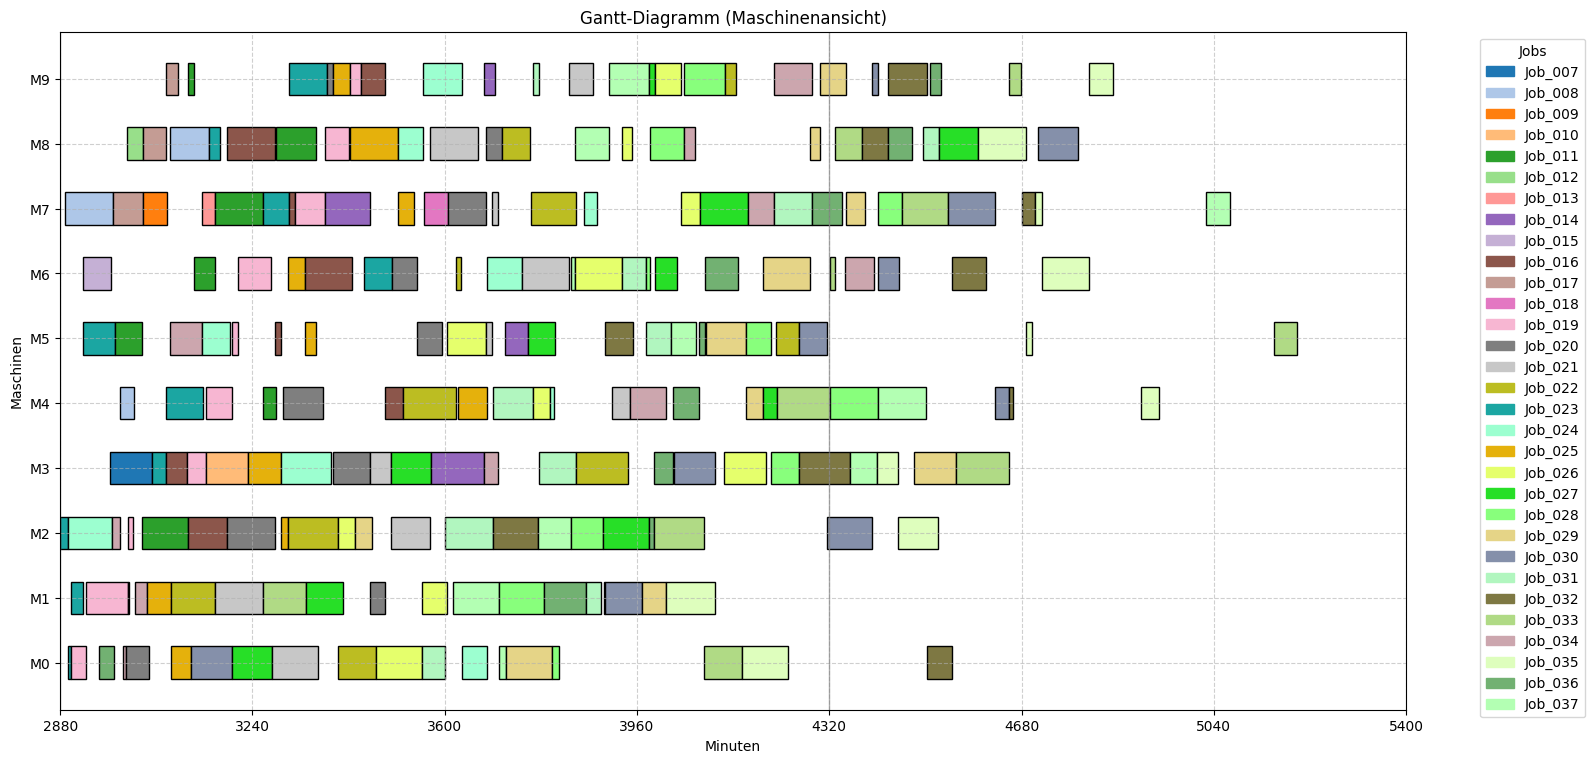

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [77]:
show.plot_gantt_machines(df_reschedule)
check.is_machine_conflict_free(df_reschedule)
check.is_operation_sequence_correct(df_reschedule)
check.is_job_timing_correct(df_reschedule)
check.is_start_correct(df_reschedule)

In [78]:
last_ops = df_reschedule.sort_values(['Job', 'Operation']).drop_duplicates('Job', keep='last')
show.count_column_grouped(last_ops, "Lateness", max_val = 180, steps= 60)

label
<-180           0
-180 - -120     0
-120 - -60      2
-60 - 0         2
0              19
0 - 60          4
60 - 120        2
120 - 180       1
>180            1
Name: count, dtype: int64

In [79]:
 df_execution[df_execution.Job == "Job_011"]

,Job,Operation,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
104,Job_011,0,894,M0,2506.00,112.34,1724.34,2618.34
105,Job_011,1,894,M1,2671.22,60.89,1838.11,2732.11
106,Job_011,2,894,M3,2871.04,101.35,2078.39,2972.39


In [80]:
df_reschedule[df_reschedule.Job == "Job_011"]

,Job,Operation,Arrival,Deadline,Machine,Start,Processing Time,End,Lateness,Tardiness,Earliness
13,Job_011,3,894,3345,M5,2983,51,3034,-311,0,311
21,Job_011,4,894,3345,M2,3034,85,3119,-226,0,226
34,Job_011,5,894,3345,M9,3119,11,3130,-215,0,215
37,Job_011,6,894,3345,M6,3130,40,3170,-175,0,175
44,Job_011,7,894,3345,M7,3170,89,3259,-86,0,86
51,Job_011,8,894,3345,M4,3259,26,3285,-60,0,60
56,Job_011,9,894,3345,M8,3285,74,3359,14,14,0


### Combi aus Simulation und Neuplannung

In [81]:
# Relevante Spalten
columns_needed = ["Job", "Operation", "Arrival", "Machine", "Start", "Processing Time", "End"]

# Spalte in df_execution umbenennen
df_execution_important_renamed = df_execution.rename(columns={"Simulated Processing Time": "Processing Time"})

# Auf die gewünschten Spalten beschränken
df_exec_trimmed = df_execution_important_renamed[columns_needed]
df_resched_trimmed = df_reschedule[columns_needed]

# DataFrames zusammenführen
df_combined = pd.concat([df_exec_trimmed, df_resched_trimmed], ignore_index=True)
df_combined

,Job,Operation,Arrival,Machine,Start,Processing Time,End
0,Job_000,0,0,M0,1440.00,13.20,1453.20
1,Job_000,1,0,M1,1469.00,107.22,1576.22
2,Job_000,2,0,M2,1644.80,17.76,1662.56
3,Job_000,3,0,M3,1677.53,20.58,1698.11
4,Job_000,4,0,M4,1761.50,64.39,1825.89
...,...,...,...,...,...,...,...
375,Job_035,7,2575,M6,4718.00,89.00,4807.00
376,Job_035,8,2575,M9,4807.00,45.00,4852.00
377,Job_035,9,2575,M4,4904.00,33.00,4937.00
378,Job_037,9,2794,M7,5026.00,45.00,5071.00


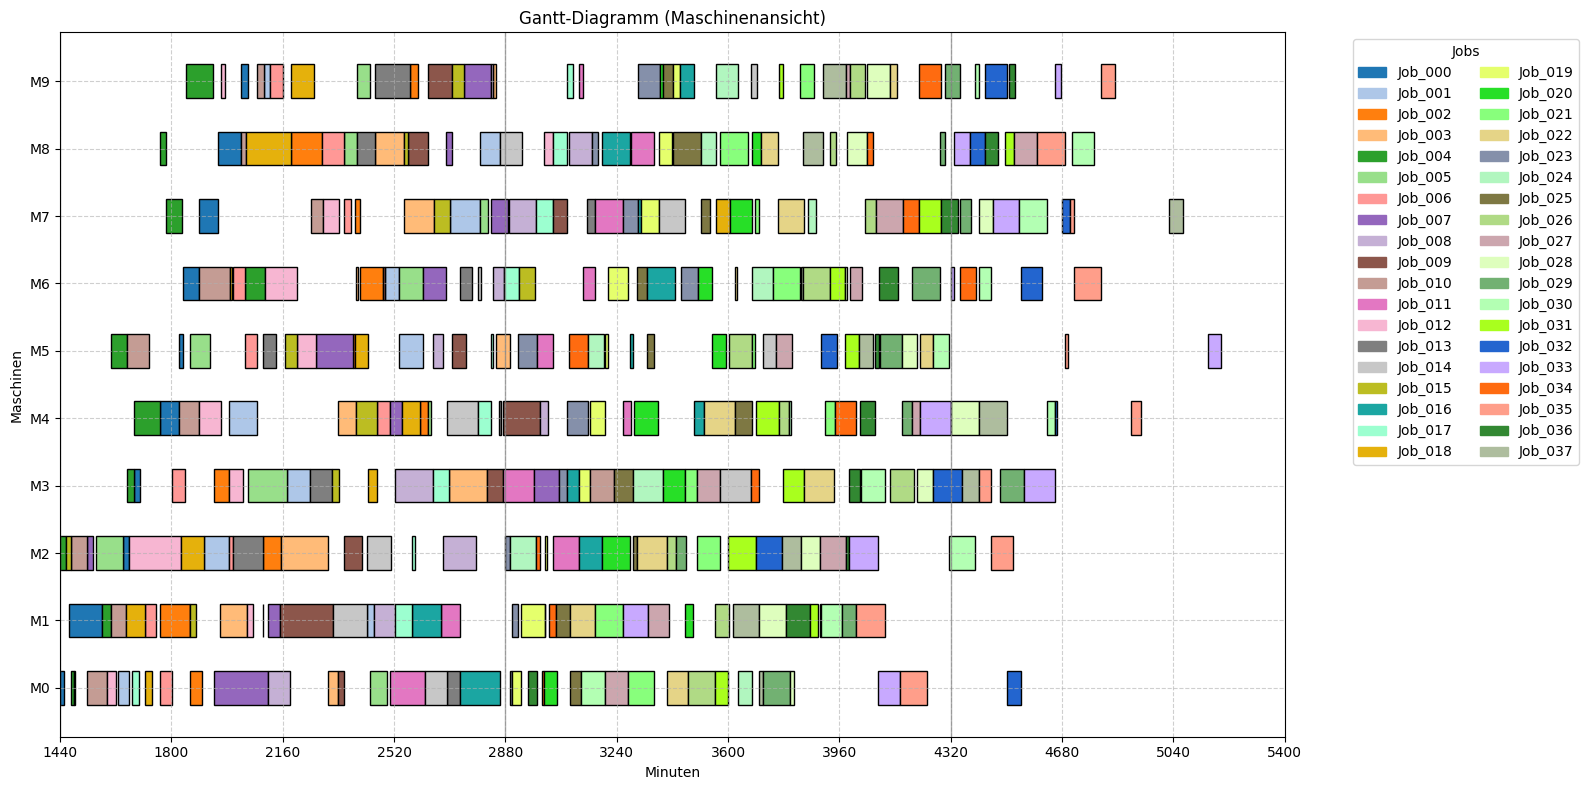

+ Keine Maschinenkonflikte gefunden
+ Alle Jobs wurden in korrekter Operationsreihenfolge ausgeführt.
+ Alle technologischen Abhängigkeiten sind eingehalten.
+ Alle Operation starten erst nach Arrival des Job


True

In [82]:
show.plot_gantt_machines(df_combined)
check.is_machine_conflict_free(df_combined)
check.is_operation_sequence_correct(df_combined)
check.is_job_timing_correct(df_combined)
check.is_start_correct(df_combined)